# (공부) 빅데이터 수업 정리
> 7주차(21/10/21~21/10/28)

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김하영

---

### import 

In [1]:
import torch 
from fastai.vision.all import * 

In [2]:
import graphviz

In [3]:
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+ s + ';}')

### data 

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
path.ls()

(#3) [Path('/home/khy/.fastai/data/mnist_sample/train'),Path('/home/khy/.fastai/data/mnist_sample/valid'),Path('/home/khy/.fastai/data/mnist_sample/labels.csv')]

`-` list 

In [6]:
threes=(path/'train'/'3').ls()
sevens=(path/'train'/'7').ls()

`-` list $\to$ image 

In [7]:
Image.open(threes[4])

`-` image $\to$ tensor 

In [8]:
tensor(Image.open(threes[4]))

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  36, 211, 254, 254,
         241, 144, 144,  35,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [9]:
seven_tensor = torch.stack([tensor(Image.open(i)) for i in sevens]).float()/255
three_tensor = torch.stack([tensor(Image.open(i)) for i in threes]).float()/255

`-` $X$와 $y$를 만들자. 

In [10]:
seven_tensor.shape, three_tensor.shape

(torch.Size([6265, 28, 28]), torch.Size([6131, 28, 28]))

In [11]:
y=torch.tensor([0.0]*6265+ [1.0]*6131).reshape(12396,1)

In [12]:
X=torch.vstack([seven_tensor,three_tensor]).reshape(12396,-1)

In [13]:
X.shape, y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [16]:
28*28

784

In [14]:
X=X.reshape(12396,1,28,28)

In [15]:
X.shape

torch.Size([12396, 1, 28, 28])

---

### 6주차 MNIST 예제) MLP 모형 

${\bf X} \to {\bf WX+b} \to f({\bf WX+b}) \to \dots \to {\bf y}$
- ${\bf X}=12396 \times 784$ matrix 
- ${\bf y}=12396 \times 1$ (col) vector

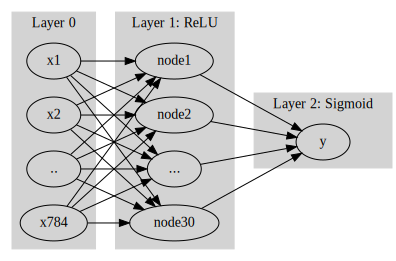

In [17]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node30"
    "x2" -> "node30"
    ".." -> "node30"
    "x784" -> "node30"


    label = "Layer 1: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node30" -> "y"
    label = "Layer 2: Sigmoid"
}
''')

`-` 왜 28$\times$28 이미지를 펼쳐서 784개의 벡터로 만든 다음에 모형을 돌려야 하는가? 

`-` 기존에 개발된 모형이 회귀분석 기반으로 되어있어서 결국 **회귀분석 틀에 짜 맞추어서 이미지자료를 분석하는 느낌** 

`-` observation의 차원은 $784$가 아니라 $1\times (28\times 28)$이 되어야 맞다. 
> 예제는 흑백이라서 $1\times(28\times28)$로 나타나고, 컬러인 경우에는 $3\times(28\times28)$

---

### 예제 1) 직접네트워크설계, pytorch

#### 2d convolution with windowsize=5

In [18]:
c1=torch.nn.Conv2d(1,16,5) # 입력채널=1 (흑백이므로), 출력채널=16, 윈도우크기5 

In [19]:
X.shape, c1(X).shape

(torch.Size([12396, 1, 28, 28]), torch.Size([12396, 16, 24, 24]))

> **X.shape는 28인데 왜 c1(X).shape는 24인가요?**  
윈도우 사이즈가 5씩 움직이다 보면, 첫 시작 윈도우는 1-5, 마지막 윈도우는 24-28이 된다.  
$\to$ 약간 겹치는 부분이 생기다 보니 $28\times 28$행렬에서 $24\times 24$로 차원이 변함

> **1에서 16으로 변한 것은 뭐지?**  
  1개 이미지를 16개로 나눈 것 ! (뻥튀기 했다)

#### MaxPool2d

> MaxPooling의 역할은 데이터의 단순화$\to$저화질로 변함  

In [22]:
m1=torch.nn.MaxPool2d(2)

In [23]:
X.shape,c1(X).shape,m1(c1(X)).shape

(torch.Size([12396, 1, 28, 28]),
 torch.Size([12396, 16, 24, 24]),
 torch.Size([12396, 16, 12, 12]))

#### ReLU 

> 비선형 과정 추가, ReLU는 0보다 크면 살리고, 0보다 작으면 날리는 방식으로 작동함 

In [24]:
a1=torch.nn.ReLU()

In [25]:
X.shape,c1(X).shape, m1(c1(X)).shape, a1(m1(c1(X))).shape

(torch.Size([12396, 1, 28, 28]),
 torch.Size([12396, 16, 24, 24]),
 torch.Size([12396, 16, 12, 12]),
 torch.Size([12396, 16, 12, 12]))

#### flatten 

In [26]:
class Flatten(torch.nn.Module):
    def forward(self,x): 
        return x.reshape(12396,-1)

In [28]:
flatten=Flatten()

In [29]:
X.shape,c1(X).shape, m1(c1(X)).shape, a1(m1(c1(X))).shape, flatten(a1(m1(c1(X)))).shape

(torch.Size([12396, 1, 28, 28]),
 torch.Size([12396, 16, 24, 24]),
 torch.Size([12396, 16, 12, 12]),
 torch.Size([12396, 16, 12, 12]),
 torch.Size([12396, 2304]))

In [30]:
16*12*12

2304

> 결국 y는 0,1의 값을 가지기 때문에 우리는 기존 신경망과 비슷하게 만들어야(펼쳐야) 함

#### linear 

In [31]:
l1=torch.nn.Linear(in_features=2304,out_features=1) 

> 2304의 디멘젼을 1로 만들자.  
  숨겨진 layer 없이 바로! 선형변환을 통해 2304의 디멘젼을 1로!

In [32]:
X.shape,\
c1(X).shape, \
m1(c1(X)).shape, \
a1(m1(c1(X))).shape, \
flatten(a1(m1(c1(X)))).shape, \
l1(flatten(a1(m1(c1(X))))).shape

(torch.Size([12396, 1, 28, 28]),
 torch.Size([12396, 16, 24, 24]),
 torch.Size([12396, 16, 12, 12]),
 torch.Size([12396, 16, 12, 12]),
 torch.Size([12396, 2304]),
 torch.Size([12396, 1]))

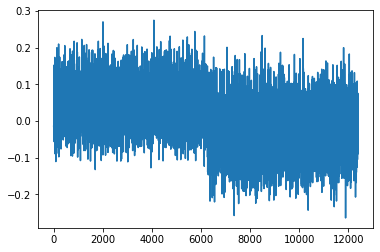

In [30]:
plt.plot(l1(flatten(a1(m1(c1(X))))).data)

- 학습이 되지 않아서 분리되지 않은 모습이다.

#### networks 설계 

In [33]:
net = nn.Sequential(c1,m1,a1,flatten,l1)
## 마지막의 sigmoid는 생략한다. torch.nn..BCEWithLogitsLoss()에 내장되어 있을것이므로 

`-` 손실함수와 옵티마이저 정의 

In [34]:
loss_fn=torch.nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(net.parameters())

`-` step1~4

In [35]:
for epoc in range(200): 
    ## 1 
    yhat=net(X)
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step()
    net.zero_grad()

> zero_grad()는 gradients 초기화 역할    
net.zero_grad() sets the gradients of all its parameters (including parameters of submodules) to zero. 

In [40]:
a2= torch.nn.Sigmoid()

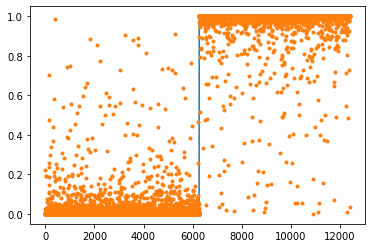

In [41]:
plt.plot(y)
plt.plot(a2(yhat.data),'.')

In [38]:
ypred=a2(yhat.data)>0.5 

In [39]:
sum(ypred==y)/12396

tensor([0.9916])

### 예제 2) 드랍아웃, 배치추가 (직접네트워크설계, pytorch+fastai) 

#### step1: dls를 만들자. 

In [42]:
ds=torch.utils.data.TensorDataset(X,y)

In [43]:
ds.tensors[0].shape  #이미지 자체가 들어간 모습

torch.Size([12396, 1, 28, 28])

- training/validation으로 나누자
- 10000개는 training, 2396개는 validation

In [44]:
ds1,ds2 = torch.utils.data.random_split(ds,[10000,2396]) 

In [45]:
dl1 = torch.utils.data.DataLoader(ds1,batch_size=500) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2396) 

- 트레이닝 데이터는 배치사이즈 500으로 나눠줬다

In [46]:
dls=DataLoaders(dl1,dl2) #여기부터 fastai

#### step2: 아키텍처, 손실함수, 옵티마이저 

In [47]:
X.shape

torch.Size([12396, 1, 28, 28])

In [48]:
class Flatten(torch.nn.Module):
    def forward(self,x): 
        return x.reshape(x.shape[0],-1)

- 이전 예제에서는 직접 값을 넣어줬는데 이번에는 열로 지정

In [49]:
net=torch.nn.Sequential(
    torch.nn.Conv2d(1,16,5), 
    torch.nn.MaxPool2d(2), 
    torch.nn.ReLU(),
    torch.nn.Dropout2d(), #dropout에도 2D!
    Flatten(),
    torch.nn.Linear(2304,1))

In [50]:
loss_fn=torch.nn.BCEWithLogitsLoss()
#optimizer= torch.optim.Adam(net.parameters()) : 러너에서 옵션으로 들어가기 때문에 주석 처리

#### step3: lrnr 생성 후 적합

In [51]:
lrnr1 = Learner(dls,net,opt_func=Adam,loss_func=loss_fn) 

In [52]:
lrnr1.fit(10)

epoch,train_loss,valid_loss,time
0,0.397018,0.187171,00:00
1,0.235679,0.080995,00:00
2,0.161680,0.061480,00:00
3,0.121357,0.052621,00:00
4,0.097048,0.047289,00:00
5,0.079746,0.043438,00:00
6,0.068439,0.041558,00:00
7,0.060553,0.040087,00:00
8,0.053907,0.038222,00:00
9,0.049199,0.036300,00:00


> **왜 10번만 돌렸을까?**  
  우리가 넣은 데이터는 총 10,000개, 배치 사이즈는 500  $\to$ 20번이 1 epoc  
  이전 예제에서 총 200번 학습하였기 때문에 10*20=200이므로 10번만 학습하면 된다.

`-` 결과를 시각화하면 아래와 같다. 

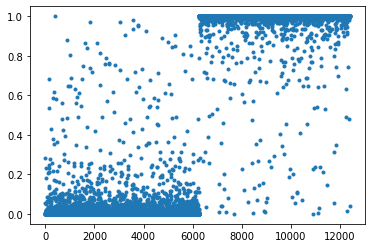

In [53]:
plt.plot(a2(net(X.to("cuda:0")).to("cpu").data),'.')

* lrnr1 분해하기!

In [60]:
print(X.shape, '--> input image')
print(lrnr1.model[0](X.to("cuda:0")).shape, '--> 2dConv')
print(lrnr1.model[1](lrnr1.model[0](X.to("cuda:0"))).shape, '--> MaxPool2d')
print(lrnr1.model[2](lrnr1.model[1](lrnr1.model[0](X.to("cuda:0")))).shape, '--> ReLU')
print(lrnr1.model[3](lrnr1.model[2](lrnr1.model[1](lrnr1.model[0](X.to("cuda:0"))))).shape, '--> Dropout2d')
print(lrnr1.model[4](lrnr1.model[3](lrnr1.model[2](lrnr1.model[1](lrnr1.model[0](X.to("cuda:0")))))).shape, '--> Flatten')
print(lrnr1.model[5](lrnr1.model[4](lrnr1.model[3](lrnr1.model[2](lrnr1.model[1](lrnr1.model[0](X.to("cuda:0"))))))).shape, '--> Linear')

torch.Size([12396, 1, 28, 28]) --> input image
torch.Size([12396, 16, 24, 24]) --> 2dConv
torch.Size([12396, 16, 12, 12]) --> MaxPool2d
torch.Size([12396, 16, 12, 12]) --> ReLU
torch.Size([12396, 16, 12, 12]) --> Dropout2d
torch.Size([12396, 2304]) --> Flatten
torch.Size([12396, 1]) --> Linear


`-` 정리: 모형은 항상 아래와 같이 2d-part 와 1d-part로 나누어진다. 
```
torch.Size([12396, 1, 28, 28]) --> input image
torch.Size([12396, 16, 24, 24]) --> 2dConv
torch.Size([12396, 16, 12, 12]) --> MaxPool2d
torch.Size([12396, 16, 12, 12]) --> ReLU
torch.Size([12396, 16, 12, 12]) --> Dropout2d
===============================================================
torch.Size([12396, 2304]) --> Flatten
torch.Size([12396, 1]) --> Linear
```

`-` 2d-part: 
- 2d선형변환: nn.torch.nn.Conv2d()
- 2d비선형변환: torch.nn.MaxPool2d(), torch.nn.ReLU()

> 선형-비선형 변환을 반복하면 특별한 특징들을 추출할 수 있음

`-` 1d-part:
- 1d선형변환: torch.nn.Linear() 
- 1d비선형변환: torch.nn.ReLU()

> **1d part에도 ReLU, Dropout을 넣기도 한다?**  
 2d part에서 그냥 우리 옛날 예제처럼 1d로 바꿔주고 1d part에서 dropout, ReLU 등을 하는 것임! 

### 예제 3) resnet34 (기존의 네트워크 사용, 순수 fastai)

`-` 데이터로부터 새로운 데이터로더스를 만들고 이를 dls2라고 하자.
* resnet34는 $3 \times 28 \times 28$ 이 기본이기 때문에 이전이 데이터로더스를 쓸 수 없음

In [54]:
path=untar_data(URLs.MNIST_SAMPLE) 
path

Path('/home/khy/.fastai/data/mnist_sample')

In [55]:
dls2=ImageDataLoaders.from_folder(
    path,
    train='train',
    valid_pct=0.2)     

`-` 러너오브젝트를 생성하고 학습하자. 

In [56]:
lrnr2=cnn_learner(dls2,resnet34,metrics=error_rate)
lrnr2.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.295091,0.136804,0.047124,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.046565,0.033614,0.013167,00:05


`-` 결과관찰

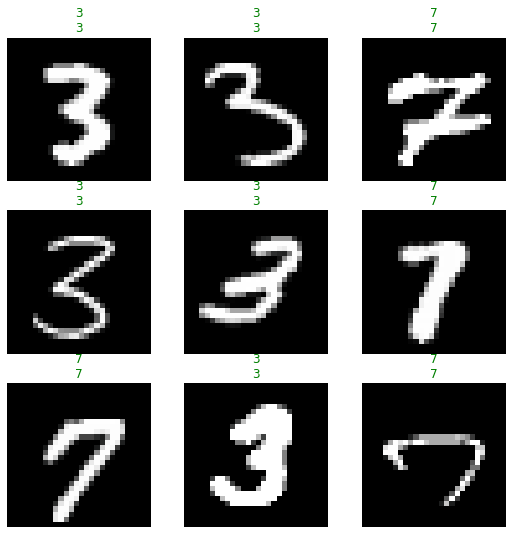

In [57]:
lrnr2.show_results()

`-` resnet은 현재 가장 성능이 좋은 모형(state of the art)중 하나이다. 

In [58]:
lrnr2.model[1] #2d part
#lrnr2.model[0] #1d part

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

`-` 특징 
- 2d-part: 입력채널이3이다, Conv2d에 padding/stride의 옵션이 있다, 드랍아웃이 없다, 배치정규화(BatchNorm1d)가 있다.
> 흑백이미지라 입력채널 1개로 충분하지만, 일반화를 위해 입력채널 3개임. 그래서 우리가 이전에 만든 dls를 쓸 수 없는 것
- 1d-part: 배치정규화가 있다, 출력의 차원이 2이다.

***DLS, Networks***
- 네트워크의 형태에 따라서 dls의 형태도 다르게 만들어야 한다. 
- MLP모형: 입력이 $784$, 첫 네트워크의 형태가 $784 \to 30$ 인 torch.nn.Linear()
- CNN모형: 입력이 $1\times 28 \times 28$, 첫 네트워크의 형태가 $1\times 28 \times 28 \to 16 \times 24 \times 24$ 인 torch.nn.Conv2d()
- Resnet34: 입력이 $3\times 28 \times 28$, 첫 네트워크의 형태가 $3\times 28 \times 28 \to 3\times 28 \times 28$ 유지

***참고***

|$y$|분포가정|마지막층의 활성화함수|손실함수(파이토치)|
|:--:|:--:|:--:|:--:|
|3.45, 4.43, ... (연속형) |정규분포|Linear|MSEloss|
|0 or 1|이항분포(베르누이)|Sigmoid| BCEloss|
|[0,0,1], [0,1,0], [1,0,0]| 다항분포|Softmax| CrossEntropyLoss|

---

### 설명가능한 CNN모형

`-` 현재까지의 모형 
- 1단계: 2d선형변환 $\to$ 2d비선형변환 
- 2단계: Flatten $\to$ MLP

`-` lrnr1모형을 다시 복습

In [59]:
lrnr1.model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Dropout2d(p=0.5, inplace=False)
  (4): Flatten()
  (5): Linear(in_features=2304, out_features=1, bias=True)
)

In [60]:
net1=torch.nn.Sequential(
    lrnr1.model[0],
    lrnr1.model[1],
    lrnr1.model[2],
    lrnr1.model[3])

In [61]:
net1(X.to('cuda:0')).shape

torch.Size([12396, 16, 12, 12])

`-` 1단계까지의 출력결과를 시각화 

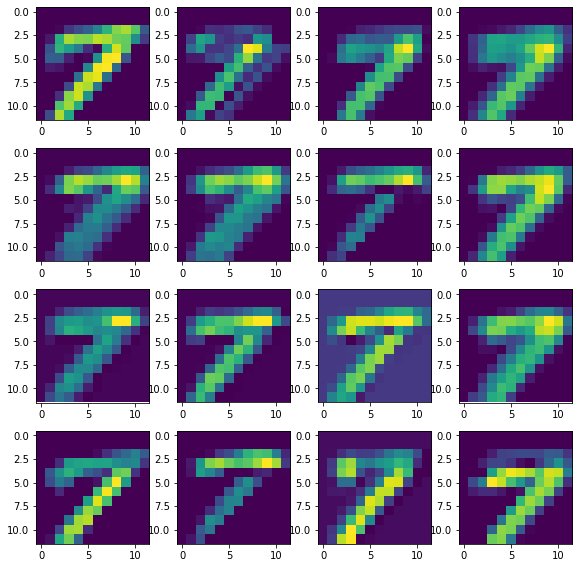

In [62]:
fig, axs = plt.subplots(4,4) 
k=0
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(net1(X.to("cuda:0"))[0][k].to("cpu").data)
        k=k+1
fig.set_figheight(8)
fig.set_figwidth(8)
fig.tight_layout()

#### net1은 유지+ net2의 구조를 변경!!

In [63]:
lrnr1.model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Dropout2d(p=0.5, inplace=False)
  (4): Flatten()
  (5): Linear(in_features=2304, out_features=1, bias=True)
)

`-` 계획 
- 변경전net2: $(n,16,12,12) \overset{flatten}{\Longrightarrow} (n,?) \overset{Linear(?,1)}{\Longrightarrow} (n,1)$
- 변경후net2: $(n,16,12,12) \overset{gap+flatten}{\Longrightarrow} (n,16) \overset{Linear(16,1)}{\Longrightarrow} (n,1)$

`-` gap: 12$\times$12 픽셀을 평균내서 하나의 값으로 대표하자.
> ap(average pooling)는 그냥 평균

In [64]:
ap=torch.nn.AdaptiveAvgPool2d(output_size=1)

In [65]:
ap(net1(X.to("cuda:0"))).shape

torch.Size([12396, 16, 1, 1])

`-` flatten 

In [66]:
flatten(ap(net1(X.to("cuda:0")))).shape

torch.Size([12396, 16])

`-` linear 

In [67]:
_l1=torch.nn.Linear(16,1,bias=False) 

In [68]:
_l1.to("cuda:0")

Linear(in_features=16, out_features=1, bias=False)

In [69]:
_l1(flatten(ap(net1(X.to("cuda:0"))))).shape

torch.Size([12396, 1])

`-` 이걸 net2로 구성하자. $\to$ (net1,net2)를 묶어서 하나의 새로운 네트워크를 만들자. 

In [70]:
net2=torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(1),
    Flatten(),
    torch.nn.Linear(16,1,bias=False))

In [71]:
net=torch.nn.Sequential(net1,net2) 
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (1): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten()
    (2): Linear(in_features=16, out_features=1, bias=False)
  )
)

`-` 수정된 네트워크로 lrnr3을 만들고 재학습

In [72]:
ds=torch.utils.data.TensorDataset(X,y)
ds1,ds2=torch.utils.data.random_split(ds,[10000,2396])
dl1=torch.utils.data.DataLoader(ds1,batch_size=1000)
dl2=torch.utils.data.DataLoader(ds2,batch_size=2396)
dls=DataLoaders(dl1,dl2)

In [73]:
lrnr3=Learner(dls,net,opt_func=Adam,loss_func=loss_fn,lr=0.1)

In [74]:
lrnr3.fit(10)

epoch,train_loss,valid_loss,time
0,0.716487,0.689939,00:00
1,0.702248,0.688443,00:00
2,0.696845,0.686715,00:00
3,0.693859,0.685074,00:00
4,0.691124,0.677512,00:00
5,0.688363,0.672192,00:00
6,0.685221,0.665444,00:00
7,0.681945,0.658962,00:00
8,0.677788,0.650641,00:00
9,0.673035,0.639372,00:00


### CAM: observation을 1개로 고정하고 net2에서 layer의 순서를 바꿔서 시각화

`-` 계획 
- 변경전net2: $(n,16,12,12) \overset{flatten}{\Longrightarrow} (n,?) \overset{Linear(?,1)}{\Longrightarrow} (n,1)$
- 변경후net2: $(n,16,12,12) \overset{gap+flatten}{\Longrightarrow} (n,16) \overset{Linear(16,1)}{\Longrightarrow} (n,1)$
- CAM: $(1,16,12,12) \overset{Linear(16,1)+flatten}{\Longrightarrow} (12,12) \overset{gap}{\Longrightarrow} 1$

`-` 준비과정1: 시각화할 샘플을 하나 준비하자. 

In [75]:
x=X[100]
X.shape,x.shape

(torch.Size([12396, 1, 28, 28]), torch.Size([1, 28, 28]))

- 차원이 다르므로 나중에 네트워크에 넣을때 문제가 생길 수 있음 $\to$ 차원을 맞춰주자

In [76]:
x=x.reshape(1,1,28,28) 

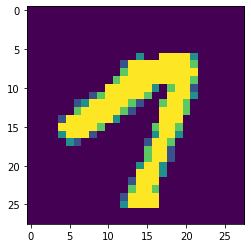

In [77]:
plt.imshow(x.squeeze())

`-` 준비과정2: 계산과 시각화를 위해서 각 네트워크를 cpu로 옮기자. (fastai로 학습한 직후라 GPU에 있음)

In [78]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten()
  (2): Linear(in_features=16, out_features=1, bias=False)
)

`-` forward확인: 이 값을 기억하자. 

In [79]:
net2(net1(x)) ## 음수이므로 class=7 이라고 CNN이 판단 

tensor([[-0.5238]], grad_fn=<MmBackward>)

`-` net2를 수정하고 forward값 확인 

In [80]:
net2

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten()
  (2): Linear(in_features=16, out_features=1, bias=False)
)

`-` 차원확인

In [81]:
net1(x).squeeze().shape

torch.Size([16, 12, 12])

In [86]:
net1(x).shape

torch.Size([1, 16, 12, 12])

In [82]:
net2[2].weight.squeeze().shape

torch.Size([16])

**Linear(in_features=16, out_features=1, bias=False)** 를 적용: 16 $\times$ (16,12,12) $\to$ (12,12) 

In [83]:
camimg=torch.einsum('i,ijk -> jk',net2[2].weight.squeeze(), net1(x).squeeze()) #어떻게 변해야 하는지를 알려줘야 함
camimg.shape

torch.Size([12, 12])

**AdaptiveAvgPool2d(output_size=1)** 를 적용

In [84]:
ap(camimg)

tensor([[-0.5238]], grad_fn=<MeanBackward1>)

★`-` 아래의 값이 같다. 

In [85]:
net2(net1(x)),ap(camimg)

(tensor([[-0.5238]], grad_fn=<MmBackward>),
 tensor([[-0.5238]], grad_fn=<MeanBackward1>))

`-` 왜냐하면 ap와 선형변환 모두 linear이므로 순서를 바꿔도 상관없음 

`-` 이제 camimg 에 관심을 가져보자. 

In [101]:
camimg

tensor([[-0.8703, -0.8703, -0.8703, -0.8703, -0.8703, -0.8703, -0.8703, -0.8703,
         -0.8703, -0.8703, -0.8703, -0.8703],
        [-0.8703, -0.8703, -0.8703, -0.8703, -0.8703, -0.0642, -0.0699,  0.0000,
          0.0000,  4.7832,  6.2696, -0.8703],
        [-0.8703, -0.8703, -0.8703, -0.8703,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  2.2098,  8.6752, -0.8703],
        [-0.8703, -0.8703, -0.8703,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000, -0.8703],
        [-0.8703, -0.4438,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000, -0.8703],
        [-0.4438,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, -0.4498, -0.8703],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, -0.8808, -0.8703],
        [ 6.4213,  7.9686,  0.0000,  0.0000, -0.1827, -0.8703,  0.0000,  0.0000,
          0.0000, -0.3028, -0.

In [102]:
ap(camimg), torch.mean(camimg)

(tensor([[-0.0378]], grad_fn=<MeanBackward1>),
 tensor(-0.0378, grad_fn=<MeanBackward0>))

`-` 결국 특정픽셀에서 큰 음의 값이 나오기 떄문에 궁극적으로는 평균이 음수가 된다. 
- 평균이 음수이다. $\leftrightarrow$ 이미지가 의미하는것이 7이다. 
- 특정픽셀이 큰 음수값을 가진다. $\leftrightarrow$ 그 픽셀에서 이미지가 7임을 뚜렷하게 알 수 있다. 

`-` 그 특정픽셀이 어딘가? 

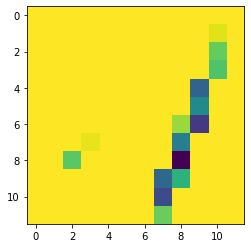

In [87]:
plt.imshow(camimg.data)

- 초록색으로 표현된 부분은 CNN모형이 이 숫자를 7이라고 생각한 근거가 된다. 

`-` 원래의 이미지와 비교

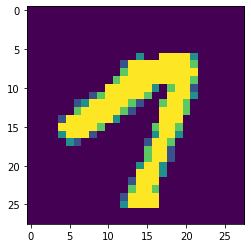

In [88]:
plt.imshow(x.squeeze()) 

`-` 두 이미지를 겹쳐보자

step1: 원래이미지를 흑백으로 그리자. 

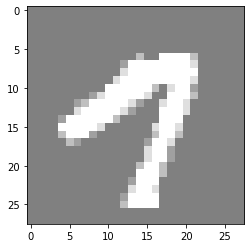

In [89]:
plt.imshow(x.squeeze(),cmap='gray',alpha=0.5)

`-` step2: 원래이미지는 (28,28)인데 camimg는 (12,12)픽셀 $\to$ camimg의 픽셀을 늘리자. 

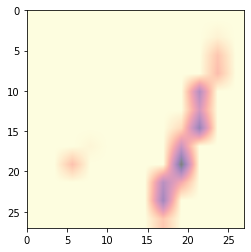

In [90]:
plt.imshow(camimg.data,alpha=0.5, extent=(0,27,27,0),interpolation='bilinear',cmap='magma')

`-` step3: 합치자.

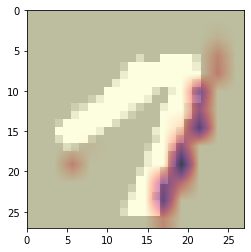

In [91]:
plt.imshow(x.squeeze(),cmap='gray',alpha=0.5)
plt.imshow(camimg.data,alpha=0.5, extent=(0,27,27,0),interpolation='bilinear',cmap='magma')